In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
import seaborn as sns

#pd.options.display.float_format = '{:.2f}'.format

from model_SARIMA import *
from model_naiv import *
from test_mean import *
from test_correlation import *
from cross_validation import *

warnings.filterwarnings("ignore")

Datensatz lesen

In [23]:
df = pd.read_csv('Walmart_Sales.csv', parse_dates=['Date'], dayfirst=True)
df.columns = df.columns.str.lower()

actual_values_dict = {}

for store in range(1, 46):
    store_df = df[df['store'] == store].copy()
    store_df.sort_values('date', inplace=True)
    store_df.set_index('date', inplace=True)

    actual_values_dict[store] = store_df['weekly_sales']

Modell wählen

In [24]:
#model_type = 'SARIMA'
model_type = 'Naive'

Alle Residuen und Fitted Values berechnen

In [25]:
fitted_values_dict = {}
residuals_dict = {}

if model_type == 'Naive':
    residuals_dict, fitted_values_dict = naive_for_all_stores('Walmart_Sales.csv')

if model_type == 'SARIMA':
    sarima_models = SARIMA_for_all_stores('Walmart_Sales.csv', whichorder = 5)


In [26]:
if model_type == 'SARIMA':
    for store in range(1, 46):
        model = sarima_models.get(store)
        fitted_values_dict[store] = model.fittedvalues.iloc[52:] # erste 52 Werte entfernen
        residuals_dict[store] = model.resid.iloc[52:] # erste 52 Werte entfernen


#pd.set_option('display.max_rows', None)
#print(residuals_dict[1])
print(len(residuals_dict[1]))

91


Residuen

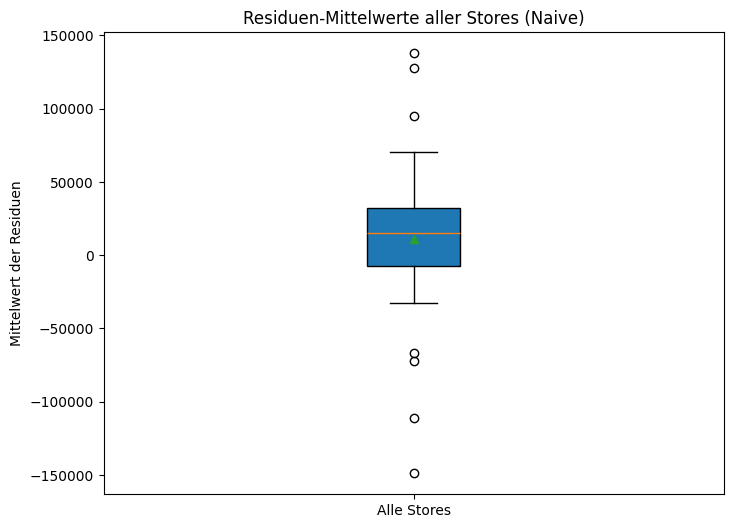

Mittelwert:  11180.275814407813
Median:  14914.96252747252


In [27]:
resid_means = []
for store in sorted(residuals_dict.keys(), key=int):
    mean_resid = residuals_dict[store].mean()
    resid_means.append(mean_resid)

# Erstelle den Boxplot der Mittelwerte
plt.figure(figsize=(8, 6))
plt.boxplot(resid_means, patch_artist=True, showmeans=True)
plt.title('Residuen-Mittelwerte aller Stores ({})'.format(model_type))
plt.ylabel("Mittelwert der Residuen")
plt.xticks([1], ["Alle Stores"])
plt.show()


print("Mittelwert: ", np.mean(resid_means))
print("Median: ", np.median(resid_means))

Korrelations Tests

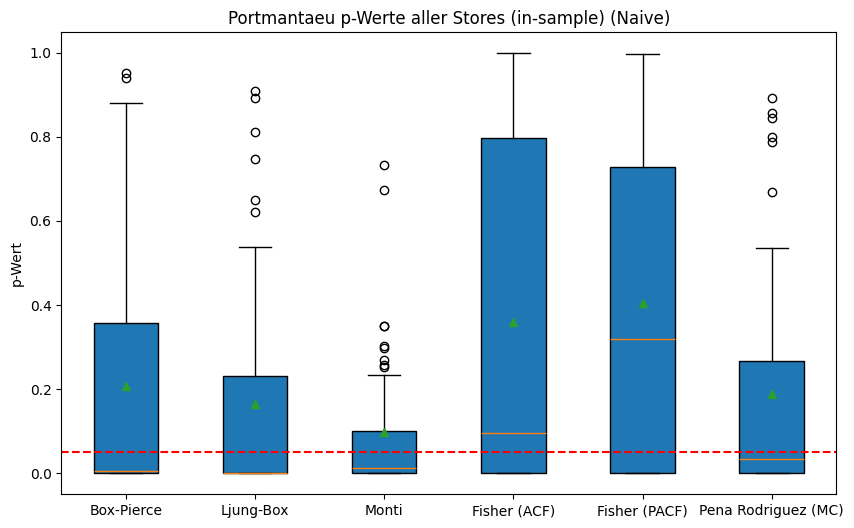

Mittelwerte: 0.20811007375882712 0.16519840955936582 0.09897806824592173 0.35876343060516075 0.40540286199831965 0.18943278943278943
Mediane: 0.004764072123817811 0.0010839886754006216 0.012255336431077346 0.09585097187611147 0.319251150209688 0.03296703296703297


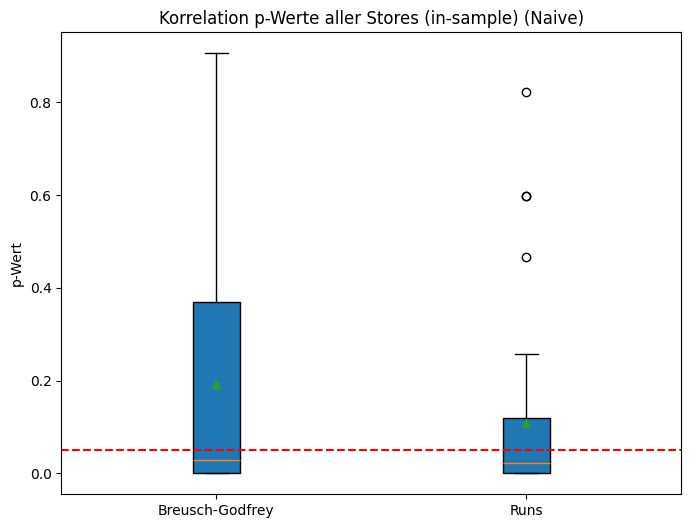

Mittelwerte: 0.19305693635673268 0.10929627533441004
Mediane: 0.029116688366855215 0.022362072853272554


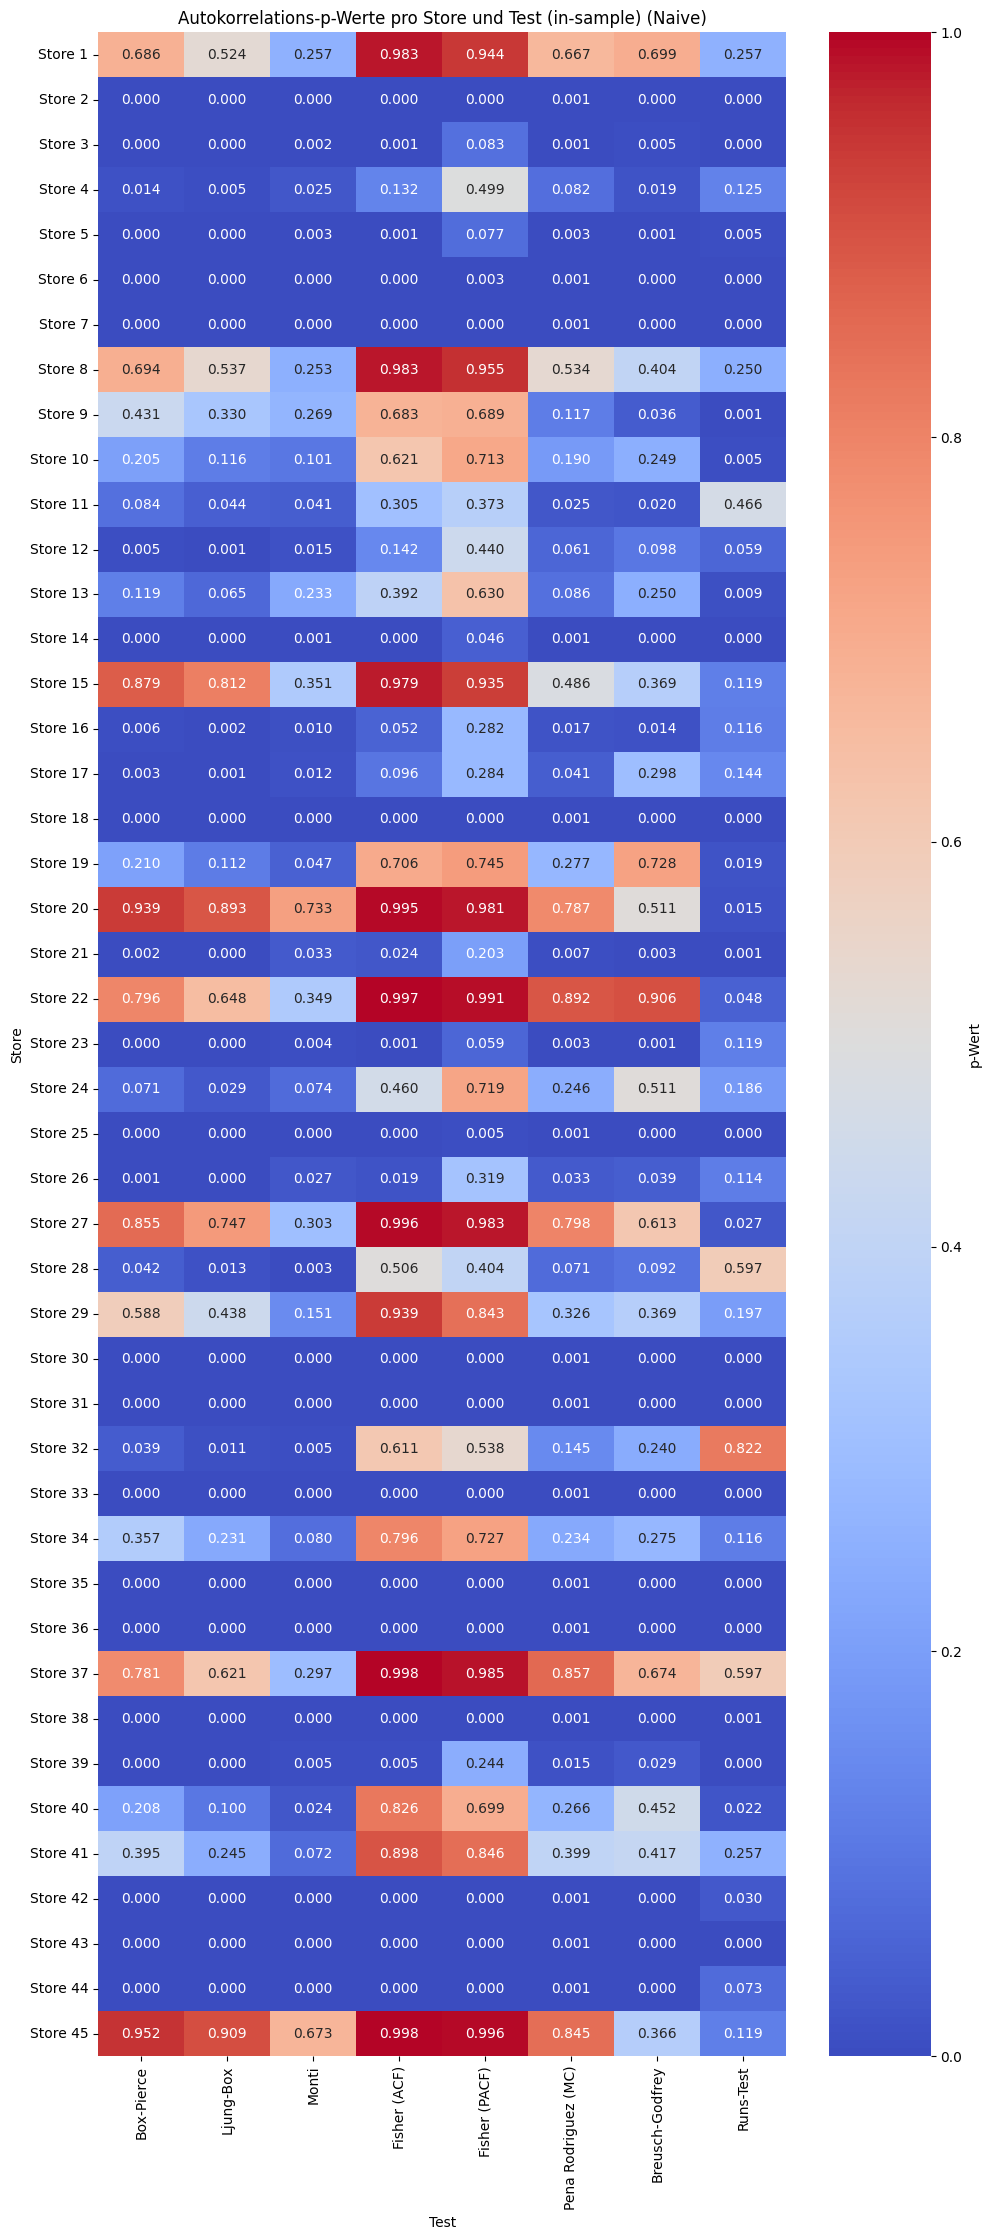

In [28]:
bp_pvalues = []
lb_pvalues = []
bg_pvalues = []
rt_pvalues = []
m_pvalues = []
f_pvalues = []
f2_pvalues = []
pr2_pvalues = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    resid = residuals_dict.get(store) #Residuen für den Store

    sales = df[df['store'] == store].copy() #Zeitreihe für den Store
    sales.set_index('date', inplace=True)
    sales = sales['weekly_sales']
    sales = sales.asfreq('W-FRI')

    if resid is not None:
        # Box-Pierce Test
        try:
            _, p_value = box_pierce_test(residuals = resid, store_num = store, model = model_type, sample = "IS", lags = 18, print_results=False)
            bp_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Box-Pierce Test für Store {store}: {e}")
            bp_pvalues.append(np.nan)
        # Ljung-Box Test
        try:
            _, p_value = ljung_box_test(residuals = resid, store_num = store, model = model_type, sample = "IS", lags=18, print_results = False)
            lb_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Ljung-Box Test für Store {store}: {e}")
            lb_pvalues.append(np.nan)
        # Breusch-Godfrey Test
        try:
            if model_type == 'SARIMA':
                _, p_value = breusch_godfrey_test(model = sarima_models[store], lags = 18, print_results = False)
            if model_type == 'Naive':
                _, p_value = breusch_godfrey_test_naive(sales, lags = 5, print_results = False)
            bg_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Breusch-Godfrey Test für Store {store}: {e}")
            bg_pvalues.append(np.nan)
        # Monti Test
        try:
            _, p_value = monti_test(residuals = resid, store_num=store, model = model_type, m = 18, print_results = False)
            m_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Monti Test für Store {store}: {e}")
            m_pvalues.append(np.nan)
        # Fisher Test (ACF)
        try:
            _, p_value = fisher_test(residuals = resid, store_num = store, model = model_type, version = "acf", m = 18, print_results = False)
            f_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Fisher Test für Store {store}: {e}")
            f_pvalues.append(np.nan)
        # Fisher Test (PACF)
        try:
            _, p_value = fisher_test(residuals = resid, store_num = store, model = model_type, version = "pacf", m = 18, print_results = False)
            f2_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Fisher Test für Store {store}: {e}")
            f2_pvalues.append(np.nan)
        # Pena Rodriguez Test (Monte Carlo)
        try:
            _, p_value = pena_rodriguez_test_mc(residuals = resid, m = 18, print_results= False)
            pr2_pvalues.append(p_value)

        except Exception as e:
            print(f"Fehler beim Pena Rodriguez Test für Store {store}: {e}")
            pr2_pvalues.append(np.nan)

        # Runs Test
        try:
            _, p_value = run_test(residuals = resid, print_results = False)
            rt_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Runs Test für Store {store}: {e}")
            rt_pvalues.append(np.nan)
    else:
        bp_pvalues.append(np.nan)
        lb_pvalues.append(np.nan)
        bg_pvalues.append(np.nan)
        rt_pvalues.append(np.nan)
        m_pvalues.append(np.nan)
        f_pvalues.append(np.nan)
        f2_pvalues.append(np.nan)
        pr2_pvalues.append(np.nan)



pvalues = np.column_stack([bp_pvalues, lb_pvalues, m_pvalues, f_pvalues, f2_pvalues, pr2_pvalues, bg_pvalues, rt_pvalues])
pvalues_portmantaeu = np.column_stack([bp_pvalues, lb_pvalues, m_pvalues, f_pvalues, f2_pvalues, pr2_pvalues])
pvalues_other = np.column_stack([bg_pvalues, rt_pvalues])


# Boxplot Portmanteau
plt.figure(figsize=(10, 6))
plt.boxplot(pvalues_portmantaeu, patch_artist=True, showmeans=True)
plt.title('Portmantaeu p-Werte aller Stores (in-sample) ({})'.format(model_type))
plt.ylabel("p-Wert")
plt.xticks([1, 2, 3, 4, 5, 6], ["Box-Pierce", "Ljung-Box",  "Monti", "Fisher (ACF)", "Fisher (PACF)", "Pena Rodriguez (MC)"])
plt.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
plt.show()

# Mittelwerte und Median der p-Werte
print("Mittelwerte:", np.mean(bp_pvalues), np.mean(lb_pvalues),  np.mean(m_pvalues), np.mean(f_pvalues), np.mean(f2_pvalues), np.mean(pr2_pvalues))
print("Mediane:", np.median(bp_pvalues), np.median(lb_pvalues),  np.median(m_pvalues), np.median(f_pvalues), np.median(f2_pvalues), np.median(pr2_pvalues))

# Boxplot Breusch-Godfrey und Runs-Test
plt.figure(figsize=(8, 6))
plt.boxplot(pvalues_other, patch_artist=True, showmeans=True)
plt.title('Korrelation p-Werte aller Stores (in-sample) ({})'.format(model_type))
plt.ylabel("p-Wert")
plt.xticks([1, 2], ["Breusch-Godfrey", "Runs"])
plt.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
plt.show()

# Mittelwerte und Median der p-Werte
print("Mittelwerte:", np.mean(bg_pvalues), np.mean(rt_pvalues))
print("Mediane:", np.median(bg_pvalues), np.median(rt_pvalues))


# Heatmap
store_names = [f"Store {i+1}" for i in range(pvalues.shape[0])]
columns = ["Box-Pierce", "Ljung-Box",  "Monti", "Fisher (ACF)", "Fisher (PACF)", "Pena Rodriguez (MC)", "Breusch-Godfrey", "Runs-Test"]
df_pvalues = pd.DataFrame(pvalues, index=store_names, columns=columns)
plt.figure(figsize=(10, len(store_names) * 0.5))  # Dynamische Höhe
sns.heatmap(df_pvalues, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={'label': 'p-Wert'}, vmin=0, vmax=1)
plt.title('Autokorrelations-p-Werte pro Store und Test (in-sample) ({})'.format(model_type))
plt.xlabel("Test")
plt.ylabel("Store")
plt.tight_layout()
plt.show()





Durbin Watson

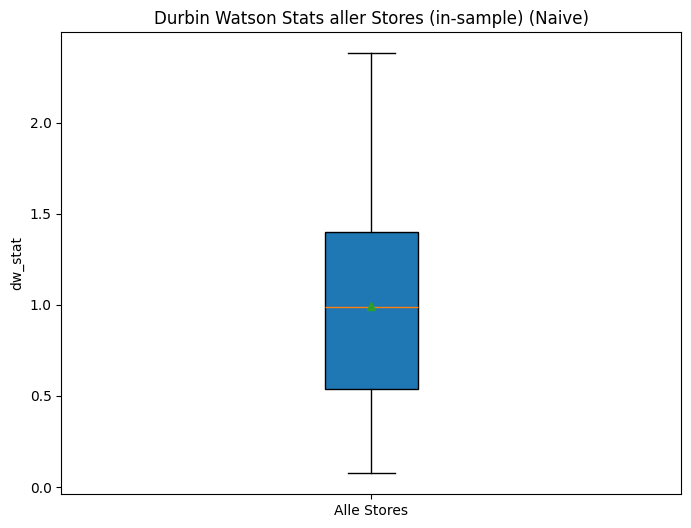

Mittelwert: 0.9930715109762402
Median: 0.9888429283314508


In [29]:
dw_stats = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    resid = residuals_dict.get(store)
    if resid is not None:
        try:
            dw_stat = durbin_watson_test(resid, False)
            dw_stats.append(dw_stat)
        except Exception as e:
            print(f"Fehler beim Durbin Watson Test für Store {store}: {e}")
            dw_stats.append(np.nan)
    else:
        dw_stats.append(np.nan)

# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(dw_stats, patch_artist=True, showmeans=True)
plt.title('Durbin Watson Stats aller Stores (in-sample) ({})'.format(model_type))
plt.ylabel("dw_stat")
plt.xticks([1], ["Alle Stores"])
plt.show()

# Mittelwerte und Median der p-Werte
print("Mittelwert:", np.mean(dw_stats))
print("Median:", np.median(dw_stats))


Mittelwert Tests

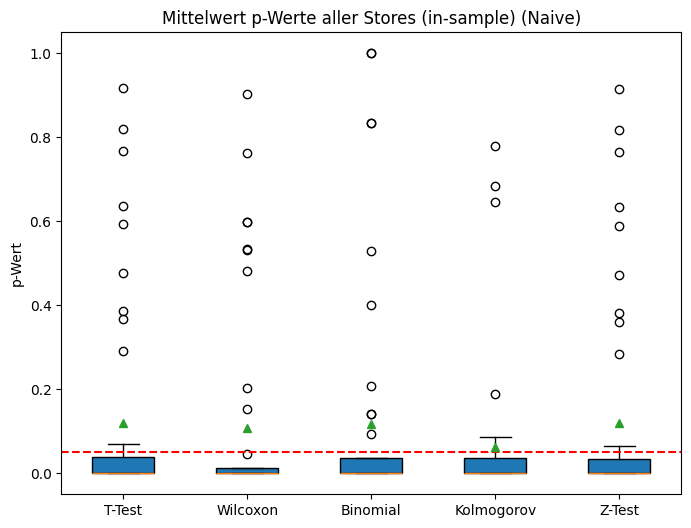

Mittelwerte: 0.12052408606622712 0.10783342325448476 0.11809732761023144 0.06280963083758036 0.11943607315774792
Mediane: 1.6606776944872748e-06 1.4303426711869889e-06 5.311762926784264e-05 2.7707115703129993e-05 2.504474655371966e-07


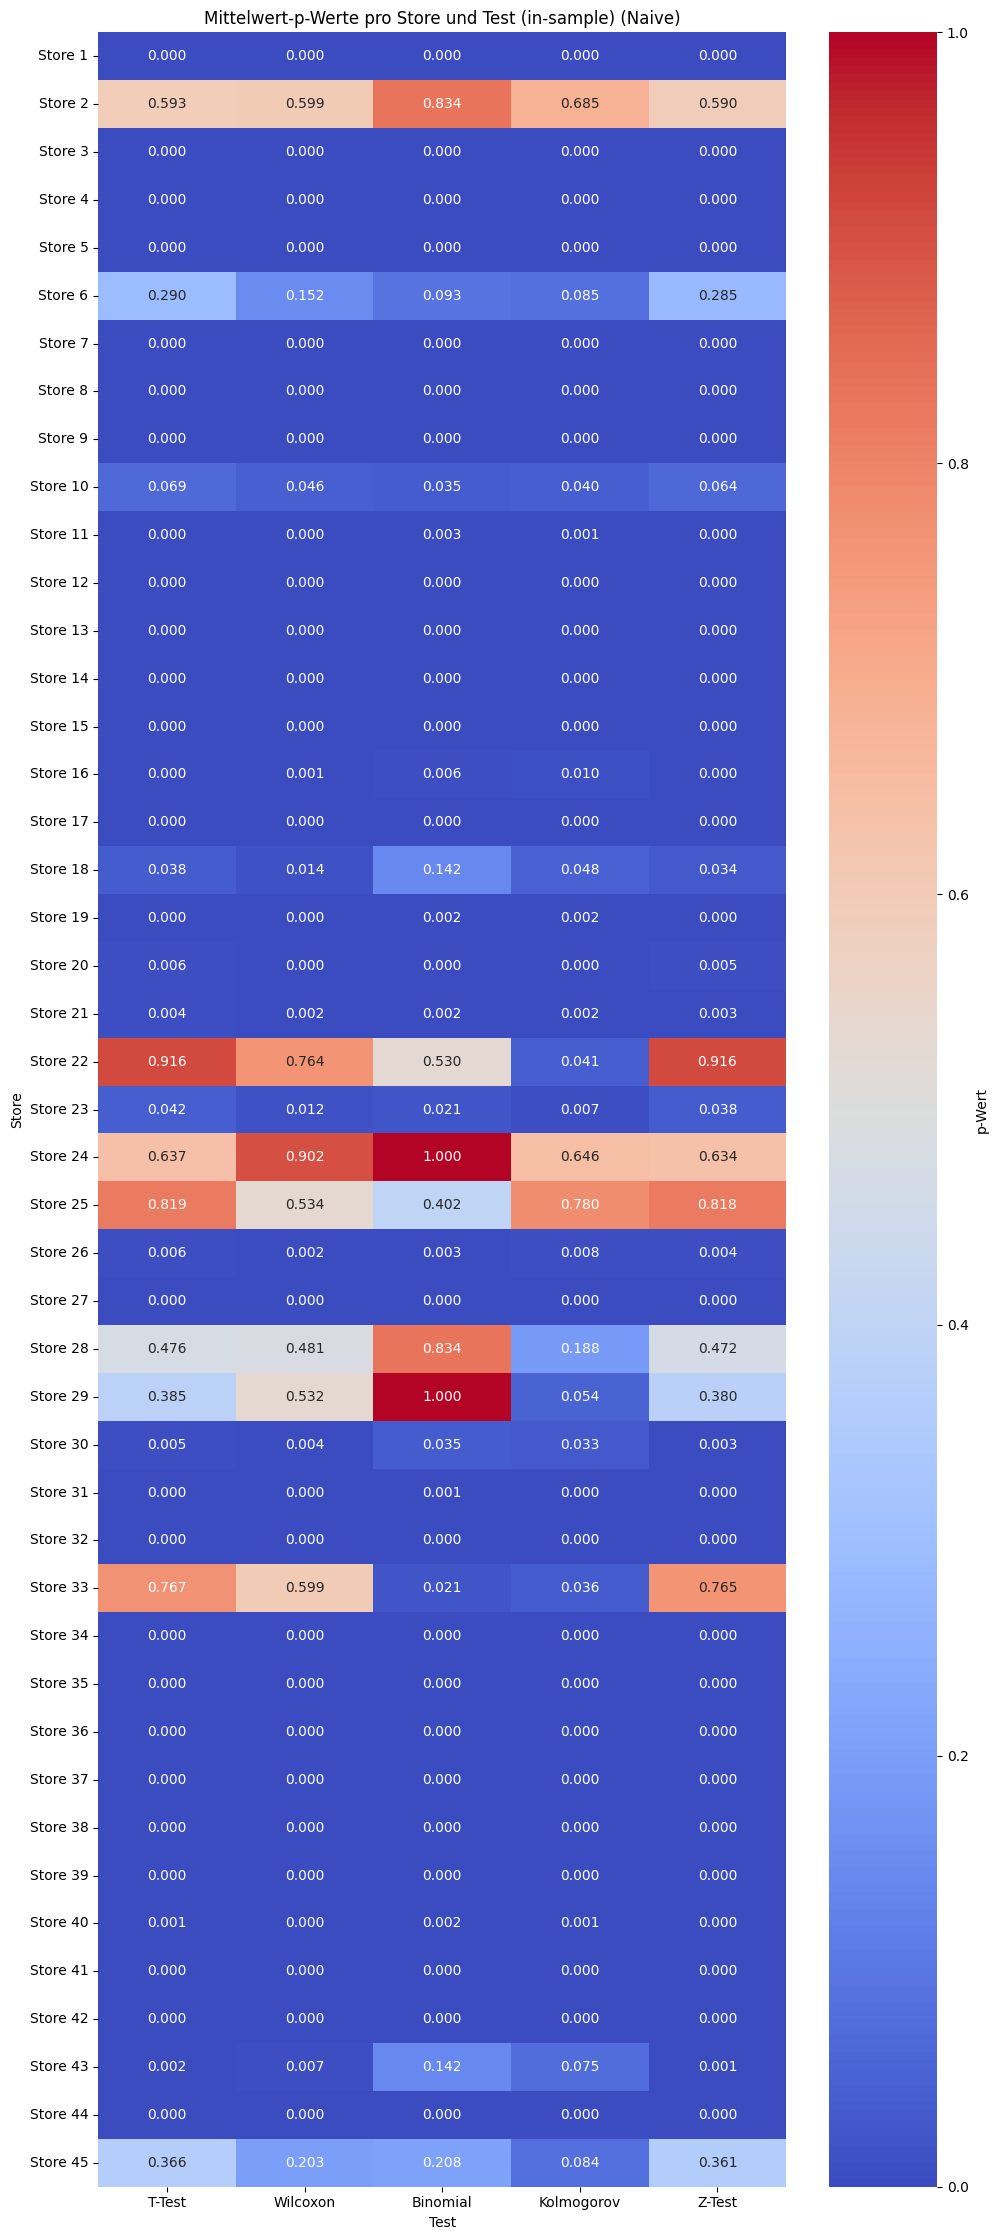

In [30]:
t_pvalues = []
w_pvalues = []
b_pvalues = []
k_pvalues = []
z_pvalues = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    resid = residuals_dict.get(store)
    if resid is not None:
        # T-Test
        try:
            _, p_value = t_test(resid, False)
            t_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim t-Test für Store {store}: {e}")
            t_pvalues.append(np.nan)
        # Wilcoxon Test
        try:
            _, p_value = wilcoxon_test(resid, False)
            w_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Wilcoxon Test für Store {store}: {e}")
            w_pvalues.append(np.nan)
        # Binomial Test
        try:
            _, _, p_value = binomial_test(resid, False)
            b_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Binomial Test für Store {store}: {e}")
            b_pvalues.append(np.nan)
        # Kolmogorov Test
        try:
            _, p_value = kolmogorov_test(resid, False)
            k_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Kolmogorov Test für Store {store}: {e}")
            k_pvalues.append(np.nan)
        # Z-Test
        try:
            _, p_value = z_test(resid, False)
            z_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Z-Test für Store {store}: {e}")
            z_pvalues.append(np.nan)
    else:
        t_pvalues.append(np.nan)
        w_pvalues.append(np.nan)
        b_pvalues.append(np.nan)
        k_pvalues.append(np.nan)
        z_pvalues.append(np.nan)


pvalues = np.column_stack([t_pvalues, w_pvalues, b_pvalues, k_pvalues, z_pvalues])


# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(pvalues, patch_artist=True, showmeans=True)
plt.title('Mittelwert p-Werte aller Stores (in-sample) ({})'.format(model_type))
plt.ylabel("p-Wert")
plt.xticks([1, 2, 3, 4, 5], ["T-Test", "Wilcoxon", "Binomial", "Kolmogorov", "Z-Test"])
plt.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
plt.show()

# Mittelwerte und Median der p-Werte
print("Mittelwerte:", np.mean(t_pvalues), np.mean(w_pvalues), np.mean(b_pvalues), np.mean(k_pvalues), np.mean(z_pvalues))
print("Mediane:", np.median(t_pvalues), np.median(w_pvalues), np.median(b_pvalues), np.median(k_pvalues), np.median(z_pvalues))


# Heatmap
store_names = [f"Store {i+1}" for i in range(pvalues.shape[0])]
columns = ["T-Test", "Wilcoxon", "Binomial", "Kolmogorov", "Z-Test"]
df_pvalues = pd.DataFrame(pvalues, index=store_names, columns=columns)
plt.figure(figsize=(10, len(store_names) * 0.5))  # Dynamische Höhe
sns.heatmap(df_pvalues, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={'label': 'p-Wert'}, vmin=0, vmax=1)
plt.title('Mittelwert-p-Werte pro Store und Test (in-sample) ({})'.format(model_type))
plt.xlabel("Test")
plt.ylabel("Store")
plt.tight_layout()
plt.show()

SMAPE

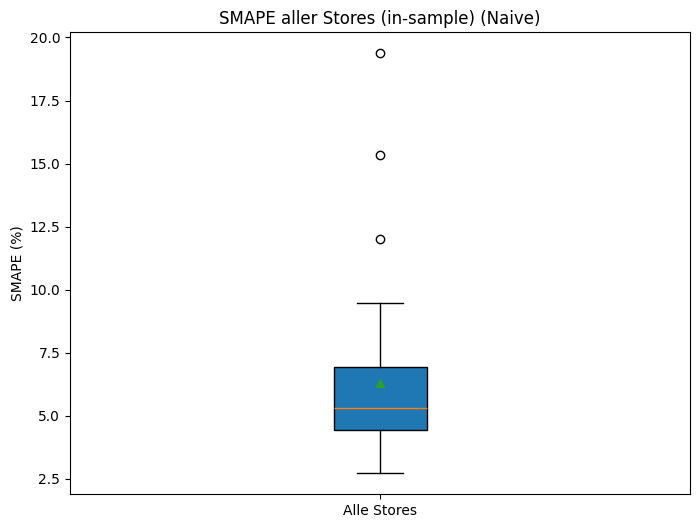

Mittelwert: 6.274514974124726 %
Median: 5.285886630418878 %


In [31]:
df = pd.read_csv('Walmart_Sales.csv', parse_dates=['Date'], dayfirst=True)
df.columns = df.columns.str.lower()

smape_stats = []

for store_id in range(1, 46):
    # fitted_values holen und in Serie umwandeln
    fitted = fitted_values_dict.get(store_id)
    if fitted is None:
        smape_stats.append(np.nan)
        continue

    # Sales-Daten für den Store
    store_df = df[df['store'] == store_id].copy()
    store_df.set_index('date', inplace=True)
    sales = store_df['weekly_sales'].asfreq('W-FRI')

    # fitted in Serie mit gleichem Index überführen
    y_pred = pd.Series(fitted, index=sales.index, name='pred')
    y_true = sales.rename('true')

    # nur Wochen, wo beide Werte vorliegen
    mask = y_pred.notna() & y_true.notna()

    y_pred_clean = y_pred[mask]
    y_true_clean = y_true[mask]

    # SMAPE
    numerator   = np.abs(y_pred_clean - y_true_clean)
    denominator = (np.abs(y_pred_clean) + np.abs(y_true_clean)) / 2

    smape_array = np.where(denominator == 0, 0, numerator / denominator)
    smape = np.nanmean(smape_array) * 100

    #print(len(smape_array))
    smape_stats.append(smape)


# Boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(smape_stats, patch_artist=True, showmeans=True)
plt.title(f'SMAPE aller Stores (in-sample) ({model_type})')
plt.ylabel("SMAPE (%)")
plt.xticks([1], ["Alle Stores"])
plt.show()

# Mittelwerte und Median der SMAPE Werte
print("Mittelwert:",np.mean(smape_stats), "%")
print("Median:",np.median(smape_stats), "%")

SMAPE vs. Autokorrelation p-Werte

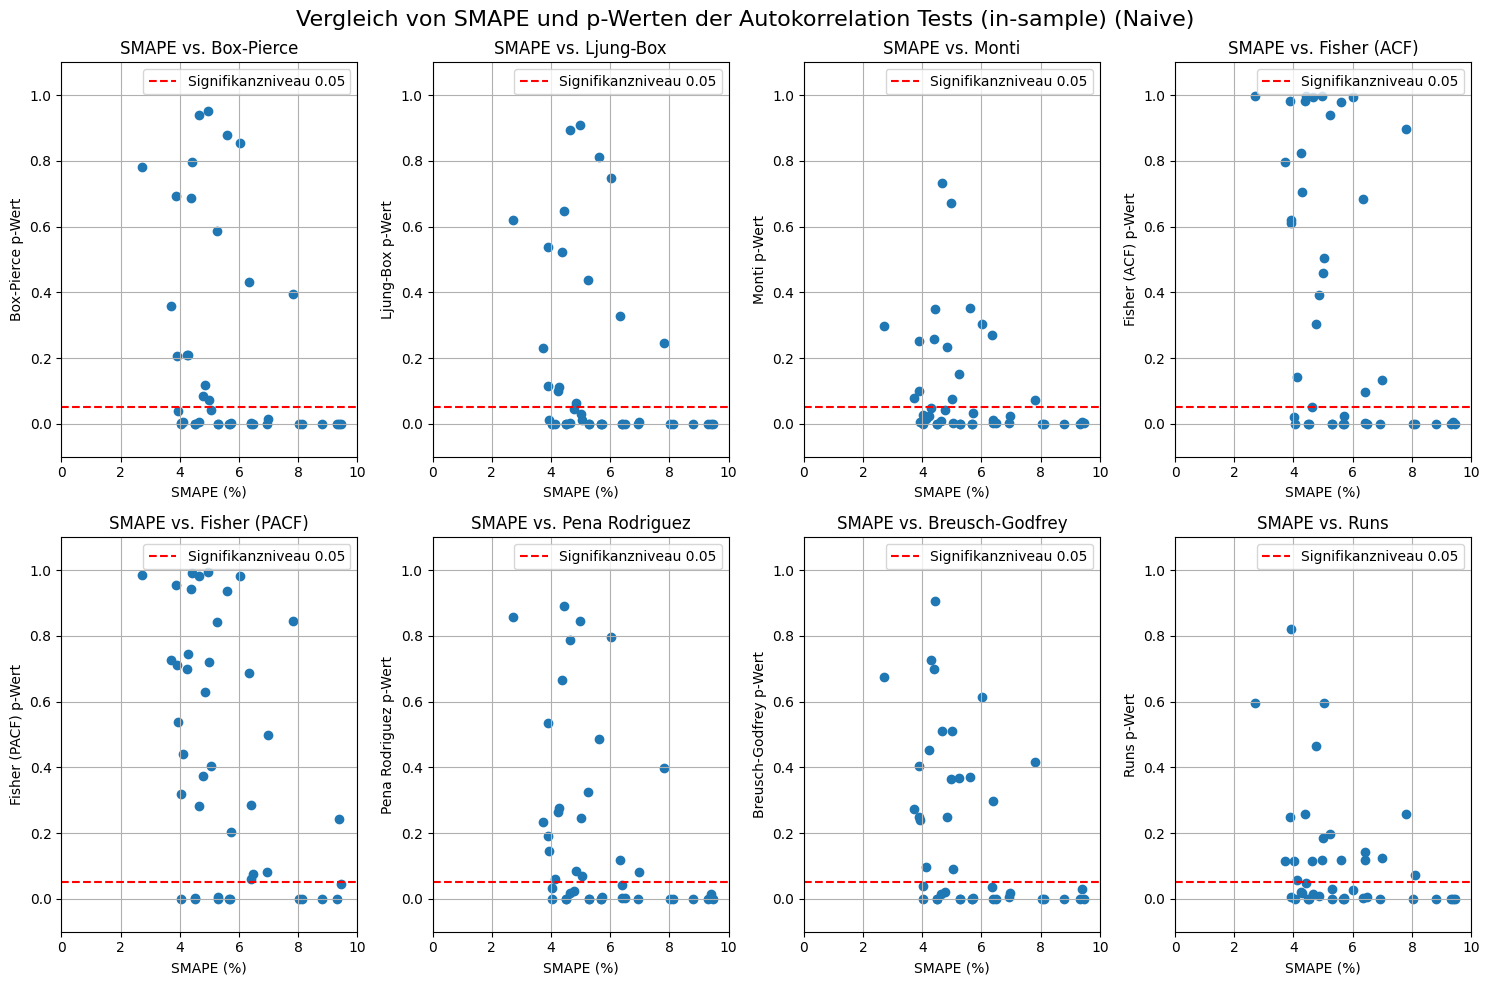

In [32]:
fig, axes = plt.subplots(2, 4, figsize=(15, 10))  # 2 Zeilen, 4 Spalten


p_values_list = [bp_pvalues, lb_pvalues, m_pvalues, f_pvalues, f2_pvalues, pr2_pvalues, bg_pvalues, rt_pvalues]
test_names = ["Box-Pierce", "Ljung-Box", "Monti", "Fisher (ACF)", "Fisher (PACF)", "Pena Rodriguez", "Breusch-Godfrey", "Runs"]

for i, ax in enumerate(axes.flat):
    ax.scatter(smape_stats, p_values_list[i])
    ax.set_xlabel('SMAPE (%)')
    ax.set_ylabel(f'{test_names[i]} p-Wert')
    ax.set_title(f'SMAPE vs. {test_names[i]}')
    ax.grid(True)
    ax.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
    ax.legend()
    ax.set_xlim(0, 10)
    ax.set_ylim(-0.1, 1.1)


fig.suptitle('Vergleich von SMAPE und p-Werten der Autokorrelation Tests (in-sample) ({})'.format(model_type), fontsize=16)
plt.tight_layout()
plt.show()

SMAPE vs Mittelwert p-Werte

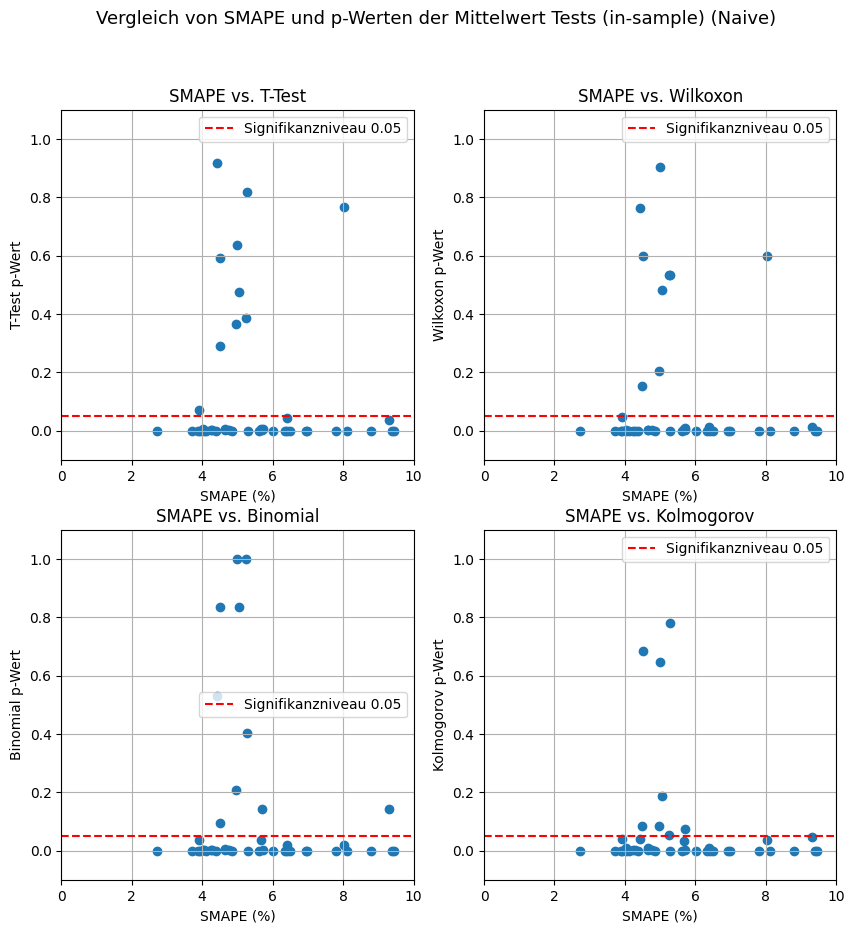

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))


p_values_list = [t_pvalues, w_pvalues, b_pvalues, k_pvalues]
test_names = ["T-Test", "Wilkoxon", "Binomial", "Kolmogorov"]

for i, ax in enumerate(axes.flat):
    ax.scatter(smape_stats, p_values_list[i])
    ax.set_xlabel('SMAPE (%)')
    ax.set_ylabel(f'{test_names[i]} p-Wert')
    ax.set_title(f'SMAPE vs. {test_names[i]}')
    ax.grid(True)
    ax.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
    ax.legend()
    ax.set_xlim(0, 10)
    ax.set_ylim(-0.1, 1.1)


fig.suptitle('Vergleich von SMAPE und p-Werten der Mittelwert Tests (in-sample) ({})'.format(model_type), fontsize=13)
plt.show()

Kreuzvalidierung

In [34]:
if model_type == 'SARIMA':
    cvs = cv_SARIMA_all_stores('Walmart_Sales.csv', whichorder = 5)
if model_type == 'Naive':
    cvs = cv_naive_all_stores('Walmart_Sales.csv')

Verarbeite Store 1 (Datenlänge: 143)...
Seasonal Naive Model Cross-Validation RMSE (period=52): 97144.8684646736
Verarbeite Store 2 (Datenlänge: 143)...
Seasonal Naive Model Cross-Validation RMSE (period=52): 104615.36896683885
Verarbeite Store 3 (Datenlänge: 143)...
Seasonal Naive Model Cross-Validation RMSE (period=52): 37454.92229852975
Verarbeite Store 4 (Datenlänge: 143)...
Seasonal Naive Model Cross-Validation RMSE (period=52): 151955.68601406078
Verarbeite Store 5 (Datenlänge: 143)...
Seasonal Naive Model Cross-Validation RMSE (period=52): 28748.730297477163
Verarbeite Store 6 (Datenlänge: 143)...
Seasonal Naive Model Cross-Validation RMSE (period=52): 84693.84606747725
Verarbeite Store 7 (Datenlänge: 143)...
Seasonal Naive Model Cross-Validation RMSE (period=52): 49408.2142091926
Verarbeite Store 8 (Datenlänge: 143)...
Seasonal Naive Model Cross-Validation RMSE (period=52): 44879.75150348725
Verarbeite Store 9 (Datenlänge: 143)...
Seasonal Naive Model Cross-Validation RMSE (per

Errors

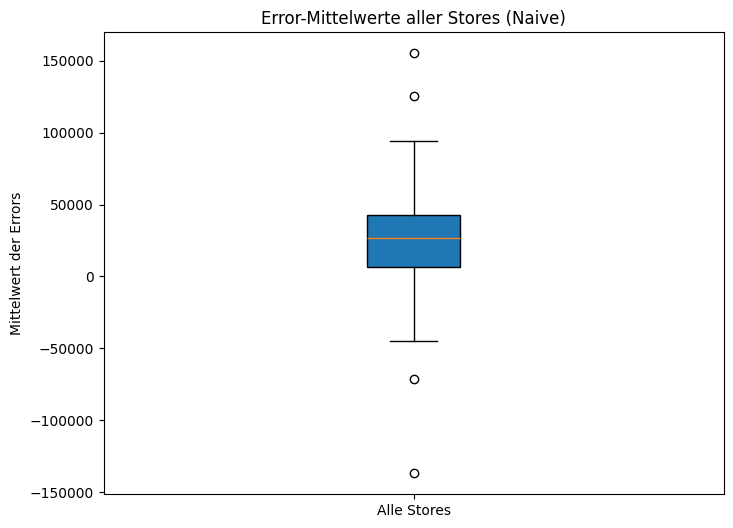

Mittelwert: 25461.58471264368
Median: 26533.59431034483


In [35]:
error_means = cvs.groupby('store')['error'].mean()


plt.figure(figsize=(8, 6))
plt.boxplot(error_means.values, patch_artist=True)
plt.ylabel('Mittelwert der Errors')
plt.title('Error-Mittelwerte aller Stores ({})'.format(model_type))
plt.xticks([1], ["Alle Stores"])
plt.show()

# Mittelwerte und Median der Error-Mittelwerte
print("Mittelwert:", np.mean(error_means))
print("Median:", np.median(error_means))


In [36]:
errors = cvs[cvs['store'] == 1]['error']
#print(errors)
print(len(errors))

58


Korrelations Test

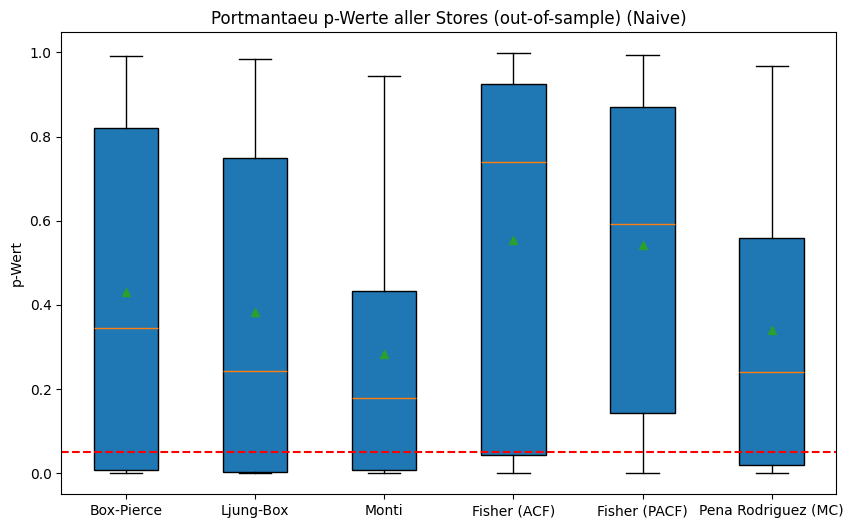

Mittelwerte: 0.4304318477155982 0.38347712923184624 0.28398852343887004 0.5543777103560628 0.5414673163220777 0.3409479409479409
Mediane: 0.34473558390919584 0.24298446808290677 0.1788042502141033 0.7395503585503289 0.5932655549924394 0.24075924075924077


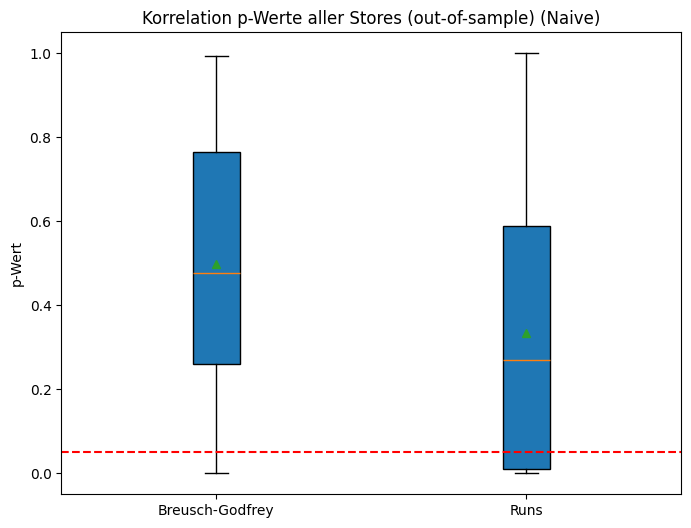

Mittelwerte: 0.4983663678860326 0.3351471920187083
Mediane: 0.4762016540086058 0.2706065524419111


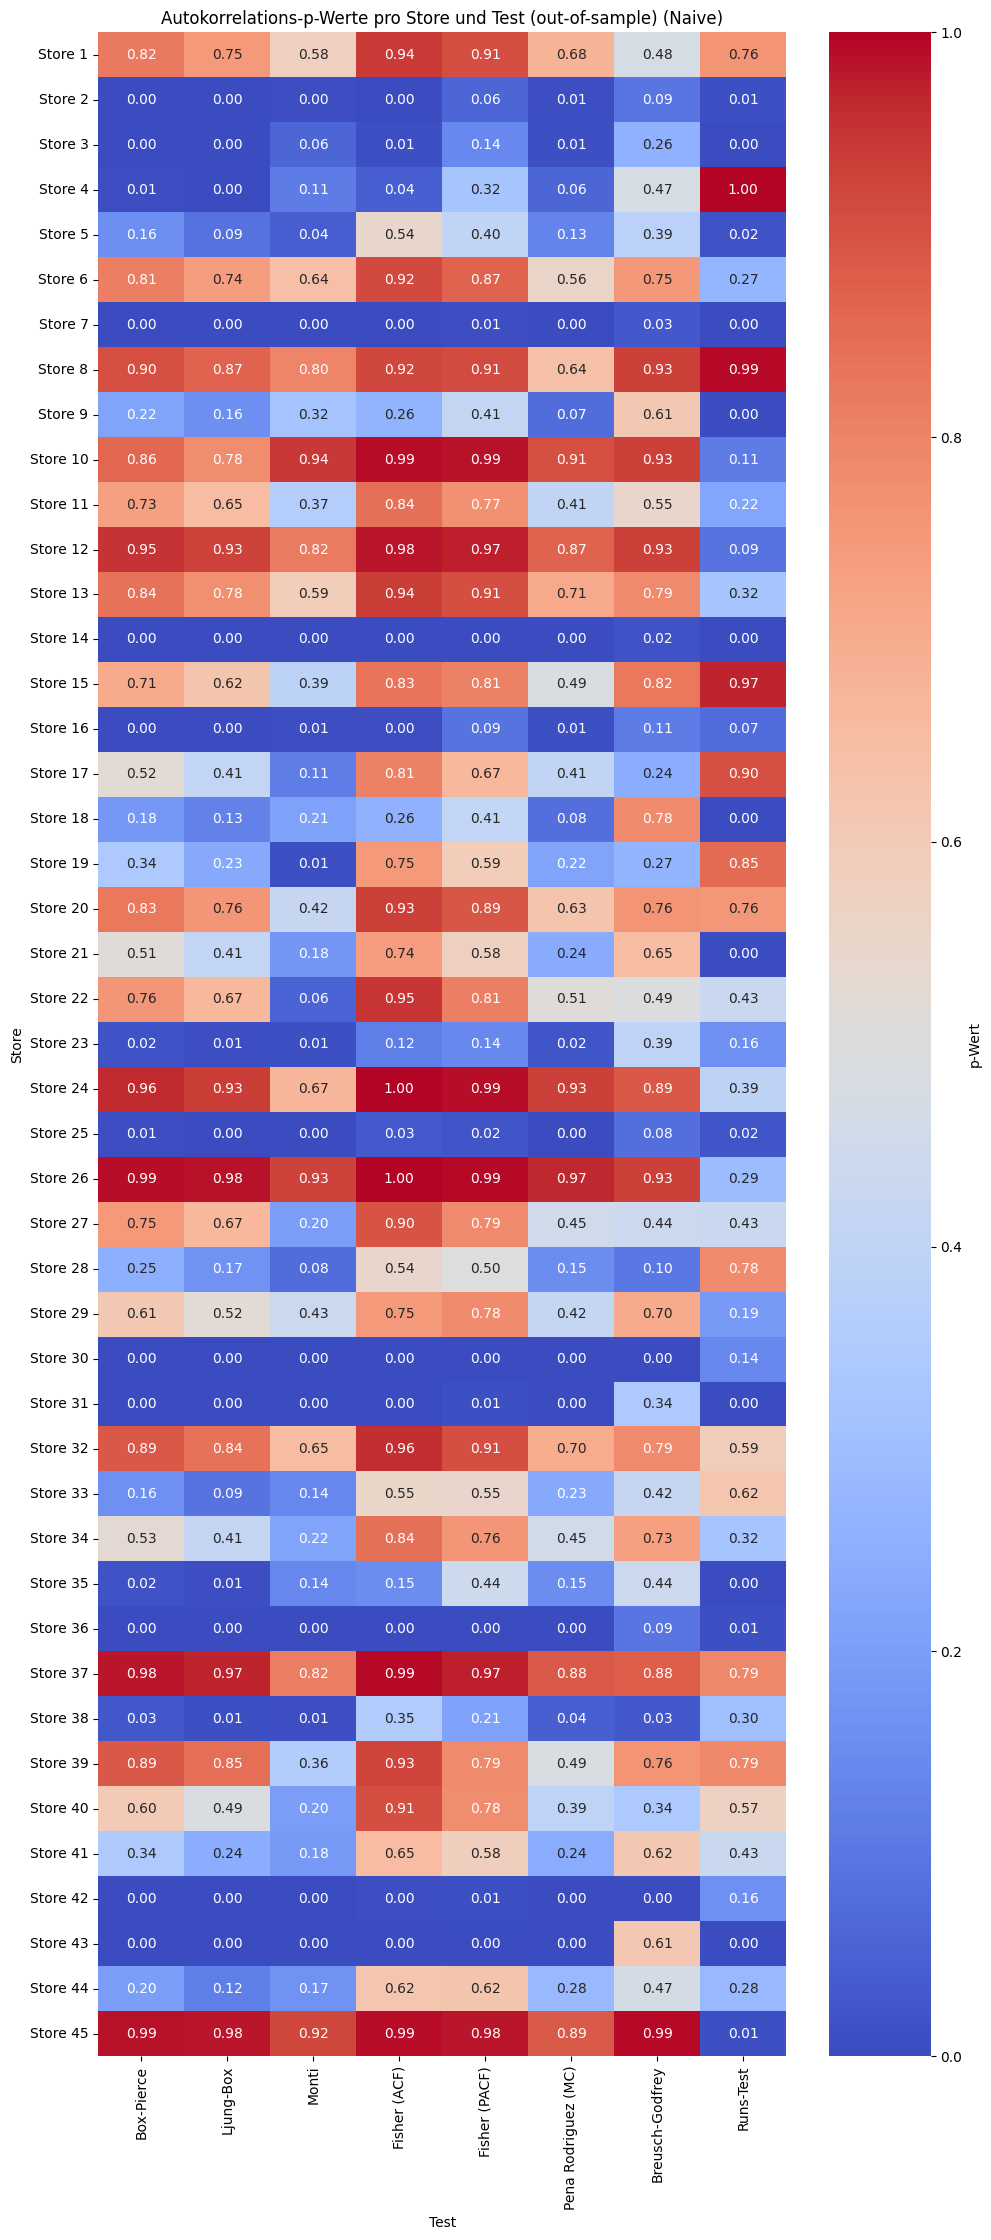

In [37]:
bp_pvalues = []
lb_pvalues = []
bg_pvalues = []
rt_pvalues = []
m_pvalues = []
f_pvalues = []
f2_pvalues = []
pr2_pvalues = []


# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    errors = cvs[cvs['store'] == store]['error']
    
    sales = df[df['store'] == store].copy() #Zeitreihe für den Store
    sales.set_index('date', inplace=True)
    sales = sales['weekly_sales']
    sales = sales.asfreq('W-FRI')

    if errors is not None:
        # Box-Pierce Test
        try:
            _, p_value = box_pierce_test(residuals = errors, store_num = store, model = model_type, sample = "OOS", lags = 10, print_results=False)
            bp_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Box-Pierce Test für Store {store}: {e}")
            bp_pvalues.append(np.nan)
        # Ljung-Box Test
        try:
            _, p_value = ljung_box_test(residuals = errors, store_num = store, model = model_type, sample = "OOS", lags = 10, print_results=False)
            lb_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Ljung-Box Test für Store {store}: {e}")
            lb_pvalues.append(np.nan)
        # Breusch-Godfrey Test
        try:
            _, p_value = breusch_godfrey_oos(residuals=errors, lags = 10)
            bg_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Breusch-Godfrey Test für Store {store}: {e}")
            bg_pvalues.append(np.nan)
        # Monti Test
        try:
            sarima_params  = optimal_orders_5.get(str(store))
            order = tuple(sarima_params["order"])
            _, p_value = monti_test(residuals = errors, store_num = store, model = model_type, m = 9, print_results = False)
            m_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Monti Test für Store {store}: {e}")
            m_pvalues.append(np.nan)
        # Fisher Test (ACF)
        try:
            sarima_params  = optimal_orders_5.get(str(store))
            order = tuple(sarima_params["order"])
            _, p_value = fisher_test(residuals = errors, store_num = store, model = model_type, version = "acf", m = 9, print_results = False)
            f_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Fisher Test für Store {store}: {e}")
            f_pvalues.append(np.nan)
        # Fisher Test (PACF)
        try:
            sarima_params  = optimal_orders_5.get(str(store))
            order = tuple(sarima_params["order"])
            _, p_value = fisher_test(residuals = errors, store_num = store, model = model_type, version = "pacf", m = 9, print_results = False)
            f2_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Fisher Test für Store {store}: {e}")
            f2_pvalues.append(np.nan)
        # Pena Rodriguez Test (Monte Carlo)
        try:
            _, p_value = pena_rodriguez_test_mc(residuals = errors, m = 9, print_results= False)
            pr2_pvalues.append(p_value)

        except Exception as e:
            print(f"Fehler beim Pena Rodriguez Test für Store {store}: {e}")
            pr2_pvalues.append(np.nan)
        # Runs Test
        try:
            _, p_value = run_test(residuals = errors, print_results=False)
            rt_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Runs Test für Store {store}: {e}")
            rt_pvalues.append(np.nan)
    else:
        bp_pvalues.append(np.nan)
        lb_pvalues.append(np.nan)
        bg_pvalues.append(np.nan)
        rt_pvalues.append(np.nan)
        m_pvalues.append(np.nan)
        f_pvalues.append(np.nan)
        f2_pvalues.append(np.nan)
        pr2_pvalues.append(np.nan)


pvalues = np.column_stack([bp_pvalues, lb_pvalues, m_pvalues, f_pvalues, f2_pvalues, pr2_pvalues, bg_pvalues, rt_pvalues])
pvalues_portmantaeu = np.column_stack([bp_pvalues, lb_pvalues, m_pvalues, f_pvalues, f2_pvalues, pr2_pvalues])
pvalues_other = np.column_stack([bg_pvalues, rt_pvalues])


# Boxplot Portmanteau
plt.figure(figsize=(10, 6))
plt.boxplot(pvalues_portmantaeu, patch_artist=True, showmeans=True)
plt.title('Portmantaeu p-Werte aller Stores (out-of-sample) ({})'.format(model_type))
plt.ylabel("p-Wert")
plt.xticks([1, 2, 3, 4, 5, 6], ["Box-Pierce", "Ljung-Box",  "Monti", "Fisher (ACF)", "Fisher (PACF)", "Pena Rodriguez (MC)"])
plt.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
plt.show()

# Mittelwerte und Median der p-Werte
print("Mittelwerte:", np.mean(bp_pvalues), np.mean(lb_pvalues),  np.mean(m_pvalues), np.mean(f_pvalues), np.mean(f2_pvalues), np.mean(pr2_pvalues))
print("Mediane:", np.median(bp_pvalues), np.median(lb_pvalues),  np.median(m_pvalues), np.median(f_pvalues), np.median(f2_pvalues), np.median(pr2_pvalues))


# Boxplot Breusch-Godfrey und Runs-Test
plt.figure(figsize=(8, 6))
plt.boxplot(pvalues_other, patch_artist=True, showmeans=True)
plt.title('Korrelation p-Werte aller Stores (out-of-sample) ({})'.format(model_type))
plt.ylabel("p-Wert")
plt.xticks([1, 2], ["Breusch-Godfrey", "Runs"])
plt.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
plt.show()

# Mittelwerte und Median der p-Werte
print("Mittelwerte:", np.mean(bg_pvalues), np.mean(rt_pvalues))
print("Mediane:", np.median(bg_pvalues), np.median(rt_pvalues))


# Heatmap
store_names = [f"Store {i+1}" for i in range(pvalues.shape[0])]
columns = ["Box-Pierce", "Ljung-Box",  "Monti", "Fisher (ACF)", "Fisher (PACF)", "Pena Rodriguez (MC)", "Breusch-Godfrey", "Runs-Test"]
df_pvalues = pd.DataFrame(pvalues, index=store_names, columns=columns)
plt.figure(figsize=(10, len(store_names) * 0.5))  # Dynamische Höhe
sns.heatmap(df_pvalues, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'p-Wert'}, vmin=0, vmax=1)
plt.title('Autokorrelations-p-Werte pro Store und Test (out-of-sample) ({})'.format(model_type))
plt.xlabel("Test")
plt.ylabel("Store")
plt.tight_layout()
plt.show()


Durbin Watson

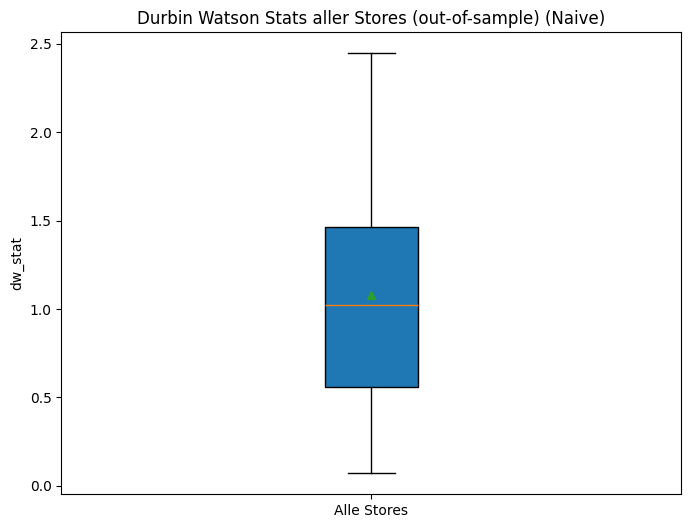

Mittelwert: 1.0788103891018517
Median: 1.024739746960642


In [38]:
dw_stats = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    error = cvs[cvs['store'] == store]['error']
    if resid is not None:
        try:
            dw_stat = durbin_watson_test(error, False)
            dw_stats.append(dw_stat)
        except Exception as e:
            print(f"Fehler beim Durbin Watson Test für Store {store}: {e}")
            dw_stats.append(np.nan)
    else:
        dw_stats.append(np.nan)

# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(dw_stats, patch_artist=True, showmeans=True)
plt.title('Durbin Watson Stats aller Stores (out-of-sample) ({})'.format(model_type))
plt.ylabel("dw_stat")
plt.xticks([1], ["Alle Stores"])
plt.show()

print("Mittelwert:", np.mean(dw_stats))
print("Median:", np.median(dw_stats))


Mittelwert Tests

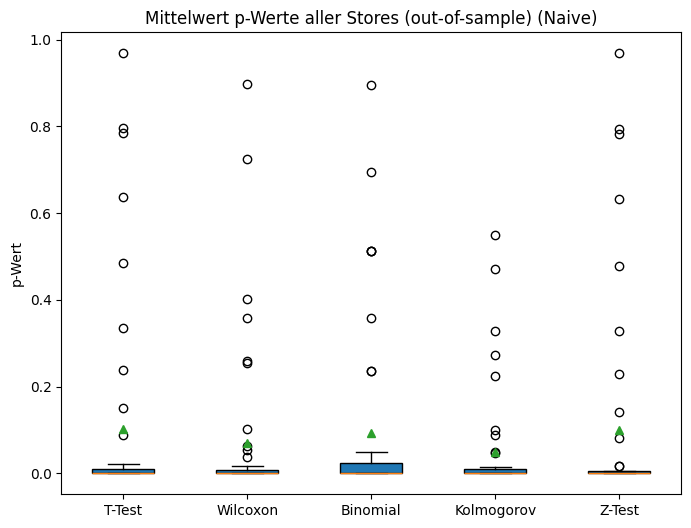

Mittelwerte: 0.1012736734662184 0.07082620723626222 0.09174923735287488 0.04839594110975701 0.09971665352561136
Mediane: 1.0068428804593193e-05 8.66820339270204e-06 3.011590962911926e-05 2.5422285445180095e-05 1.0170000521593738e-06


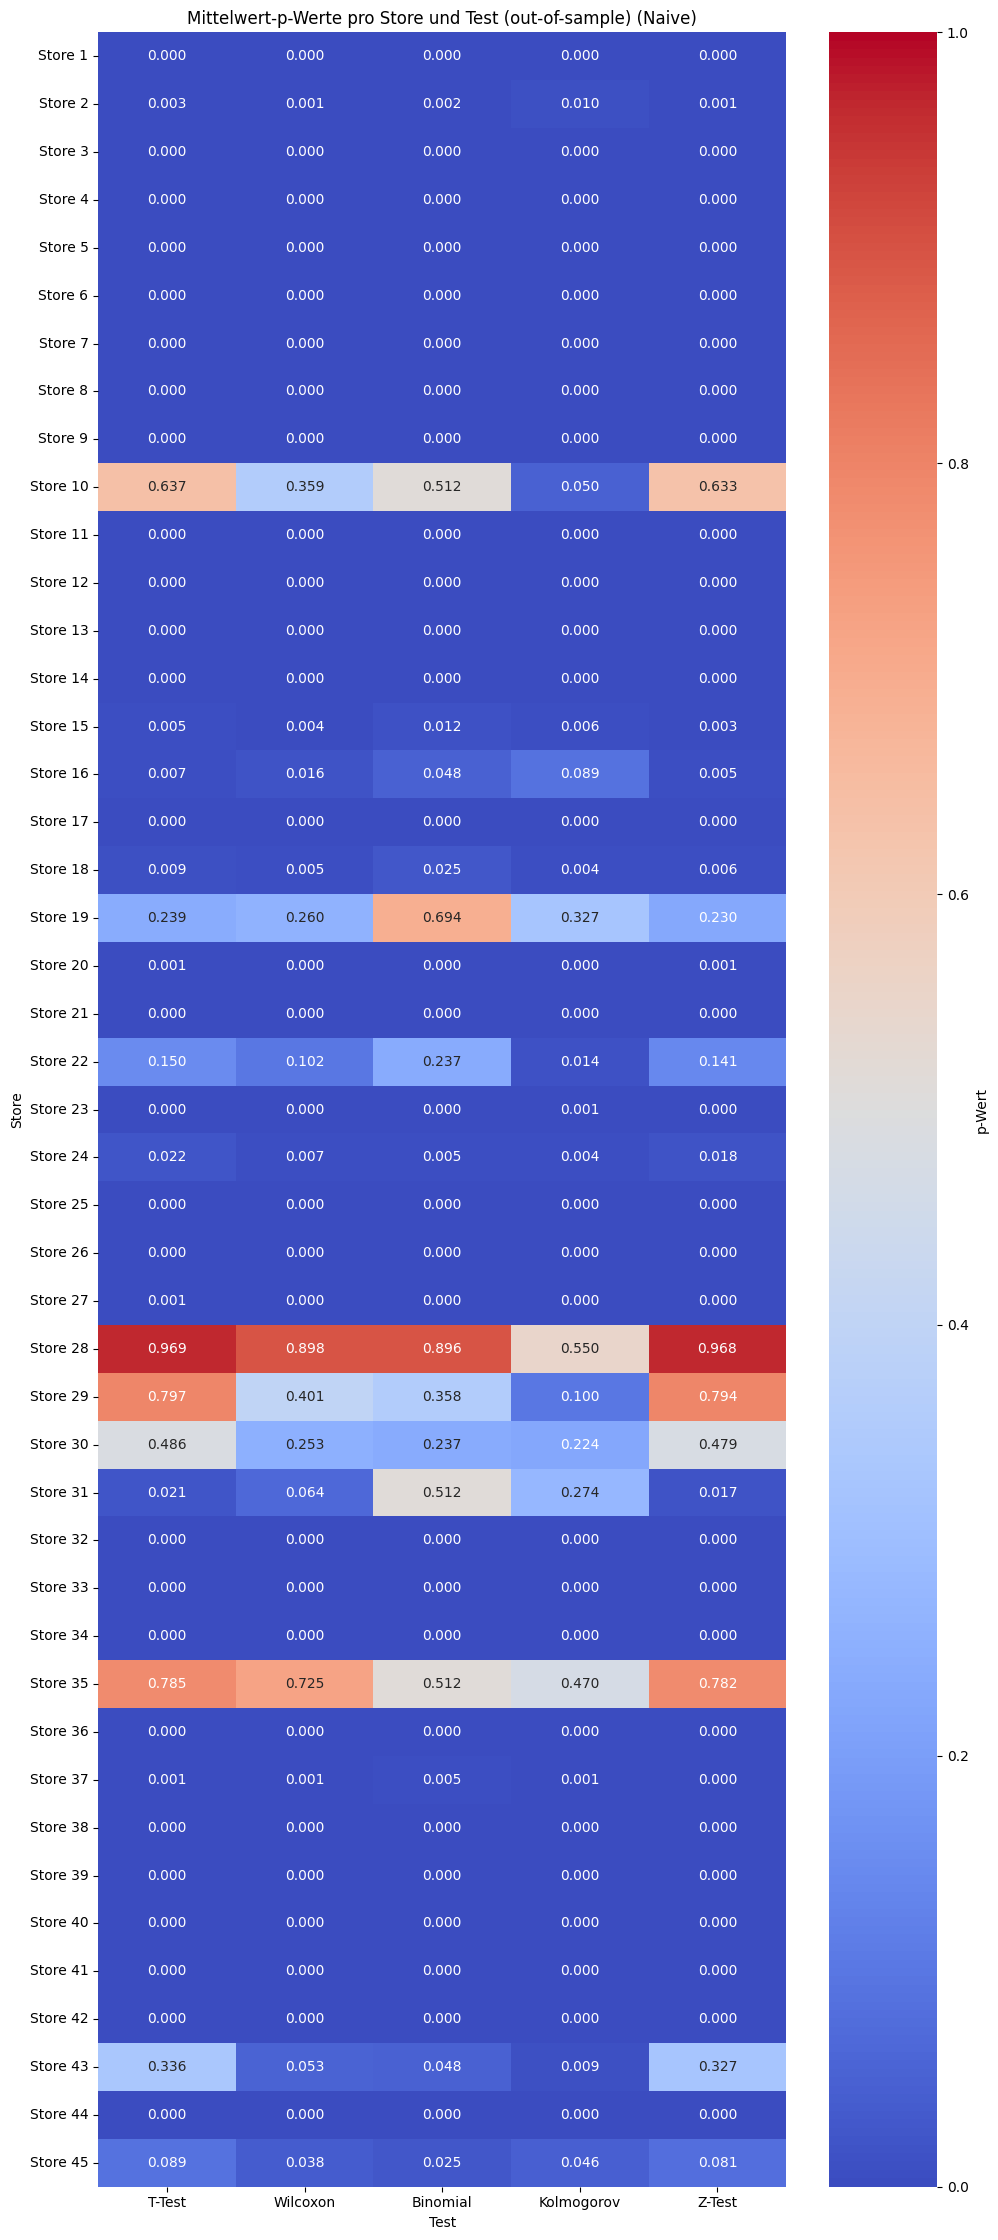

In [39]:
t_pvalues = []
w_pvalues = []
b_pvalues = []
k_pvalues = []
z_pvalues = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    errors = cvs[cvs['store'] == store]['error']
    if resid is not None:
        # T-Test
        try:
            _, p_value = t_test(errors, False)
            t_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim t-Test für Store {store}: {e}")
            t_pvalues.append(np.nan)
        # Wilcoxon Test
        try:
            _, p_value = wilcoxon_test(errors, False)
            w_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Wilcoxon Test für Store {store}: {e}")
            w_pvalues.append(np.nan)
        # Binomial Test
        try:
            _, _, p_value = binomial_test(errors, False)
            b_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Binomial Test für Store {store}: {e}")
            b_pvalues.append(np.nan)
        # Kolmogorov Test
        try:
            _, p_value = kolmogorov_test(errors, False)
            k_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Kolmogorov Test für Store {store}: {e}")
            k_pvalues.append(np.nan)
        # Z-Test
        try:
            _, p_value = z_test(errors, False)
            z_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Z-Test für Store {store}: {e}")
            z_pvalues.append(np.nan)
    else:
        t_pvalues.append(np.nan)
        w_pvalues.append(np.nan)
        b_pvalues.append(np.nan)
        k_pvalues.append(np.nan)
        z_pvalues.append(np.nan)


pvalues = np.column_stack([t_pvalues, w_pvalues, b_pvalues, k_pvalues, z_pvalues])


# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(pvalues, patch_artist=True, showmeans=True)
plt.title('Mittelwert p-Werte aller Stores (out-of-sample) ({})'.format(model_type))
plt.ylabel("p-Wert")
plt.xticks([1, 2, 3, 4, 5], ["T-Test", "Wilcoxon", "Binomial", "Kolmogorov", "Z-Test"])
plt.show()

# Mittelwerte und Median der p-Werte
print("Mittelwerte:", np.mean(t_pvalues), np.mean(w_pvalues), np.mean(b_pvalues), np.mean(k_pvalues), np.mean(z_pvalues))
print("Mediane:", np.median(t_pvalues), np.median(w_pvalues), np.median(b_pvalues), np.median(k_pvalues), np.median(z_pvalues))

# Heatmap
store_names = [f"Store {i+1}" for i in range(pvalues.shape[0])]
columns = ["T-Test", "Wilcoxon", "Binomial", "Kolmogorov", "Z-Test"]
df_pvalues = pd.DataFrame(pvalues, index=store_names, columns=columns)
plt.figure(figsize=(10, len(store_names) * 0.5))  # Dynamische Höhe
sns.heatmap(df_pvalues, annot=True, fmt=".3f", cmap="coolwarm", cbar_kws={'label': 'p-Wert'}, vmin=0, vmax=1)
plt.title('Mittelwert-p-Werte pro Store und Test (out-of-sample) ({})'.format(model_type))
plt.xlabel("Test")
plt.ylabel("Store")
plt.tight_layout()
plt.show()


SMAPE

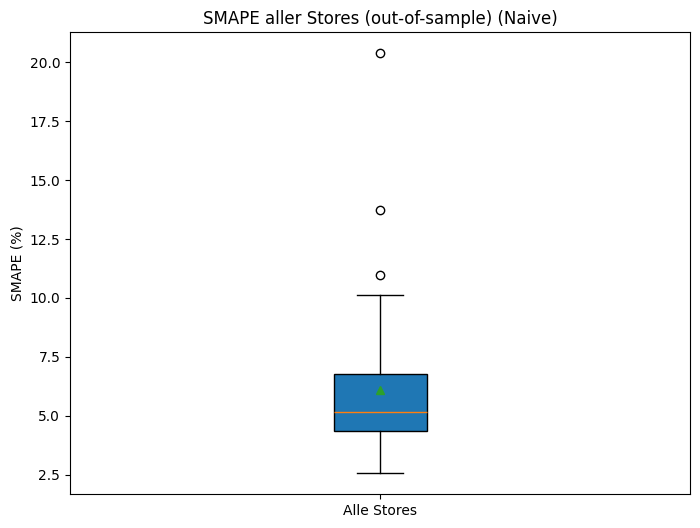

Mittelwert: 6.088989717718031 %
Median: 5.150058108888672 %


In [40]:
smape_stats = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    forecast_values = cvs[cvs['store'] == store]['forecast']
    actual_values = cvs[cvs['store'] == store]['actual']

    if len(forecast_values) > 0:
        # SMAPI Test
    
        numerator = np.abs(forecast_values - actual_values)
        denominator = (np.abs(forecast_values) + np.abs(actual_values)) / 2
        smape = np.where(denominator == 0, 0, numerator / denominator)
        smape = np.mean(smape) * 100
        try:
            smape_stats.append(smape)
        except Exception as e:
            print(f"Fehler beim SMAPI Test für Store {store}: {e}")
            smape_stats.append(np.nan)
    else:
        smape_stats.append(np.nan)

plt.figure(figsize=(8, 6))
plt.boxplot(smape_stats, patch_artist=True, showmeans=True)
plt.title('SMAPE aller Stores (out-of-sample) ({})'.format(model_type))
plt.ylabel("SMAPE (%)")
plt.xticks([1], ["Alle Stores"])
plt.show()

# Mittelwerte und Median der SMAPE Werte
print("Mittelwert:", np.mean(smape_stats), "%")
print("Median:", np.median(smape_stats), "%")

SMAPE vs. Autokorrelation p-Werte

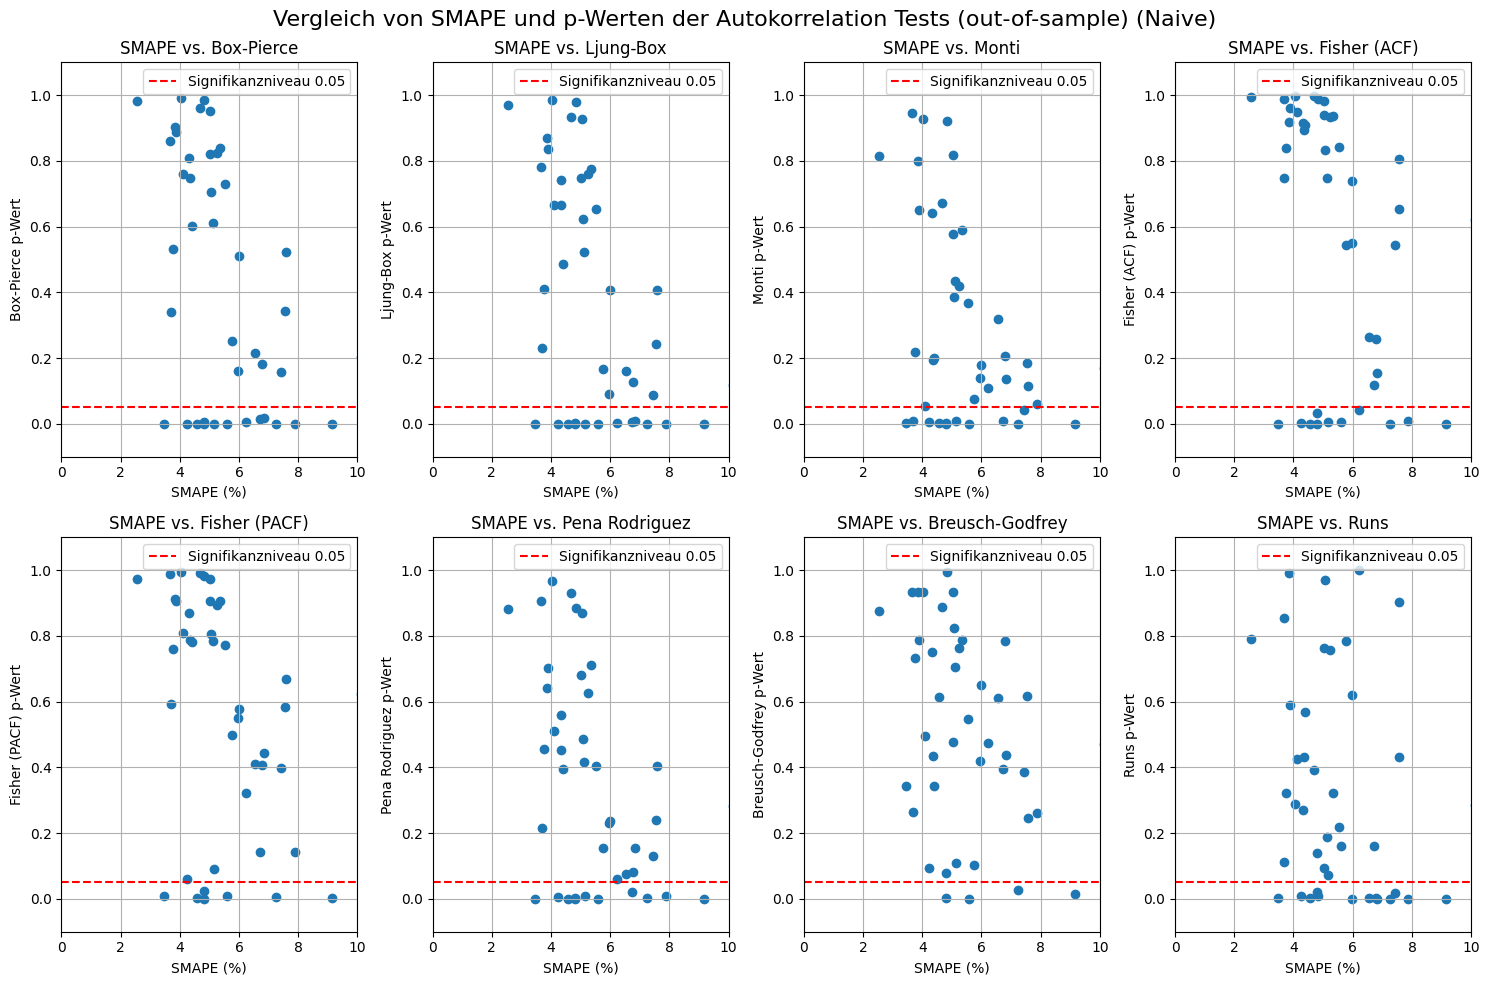

In [41]:
fig, axes = plt.subplots(2, 4, figsize=(15, 10))  # 2 Zeilen, 3 Spalten


p_values_list = [bp_pvalues, lb_pvalues, m_pvalues, f_pvalues, f2_pvalues, pr2_pvalues, bg_pvalues, rt_pvalues]
test_names = ["Box-Pierce", "Ljung-Box", "Monti", "Fisher (ACF)", "Fisher (PACF)", "Pena Rodriguez", "Breusch-Godfrey", "Runs"]

for i, ax in enumerate(axes.flat):
    ax.scatter(smape_stats, p_values_list[i])
    ax.set_xlabel('SMAPE (%)')
    ax.set_ylabel(f'{test_names[i]} p-Wert')
    ax.set_title(f'SMAPE vs. {test_names[i]}')
    ax.grid(True)
    ax.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
    ax.legend()
    ax.set_xlim(0, 10)
    ax.set_ylim(-0.1, 1.1)


fig.suptitle('Vergleich von SMAPE und p-Werten der Autokorrelation Tests (out-of-sample) ({})'.format(model_type), fontsize=16)
plt.tight_layout()
plt.show()

SMAPE vs. Mittelwert p-Werte

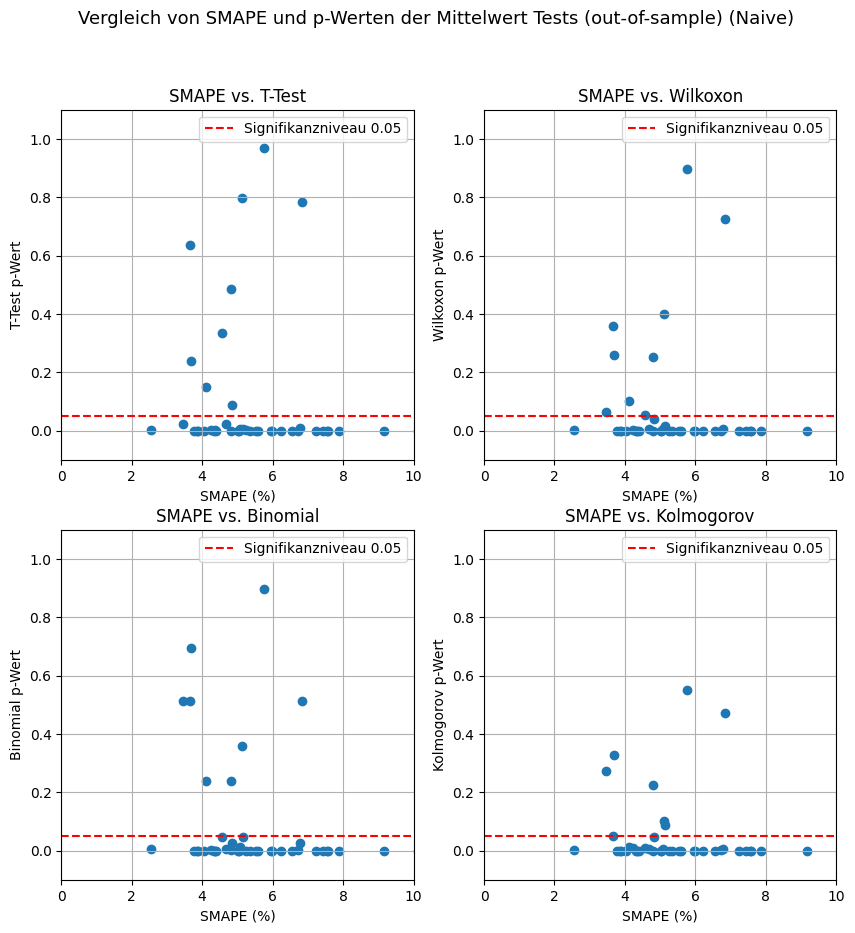

In [42]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))


p_values_list = [t_pvalues, w_pvalues, b_pvalues, k_pvalues]
test_names = ["T-Test", "Wilkoxon", "Binomial", "Kolmogorov"]

for i, ax in enumerate(axes.flat):
    ax.scatter(smape_stats, p_values_list[i])
    ax.set_xlabel('SMAPE (%)')
    ax.set_ylabel(f'{test_names[i]} p-Wert')
    ax.set_title(f'SMAPE vs. {test_names[i]}')
    ax.grid(True)
    ax.axhline(0.05, color='red', linestyle='--', label='Signifikanzniveau 0.05')
    ax.legend()
    ax.set_xlim(0, 10)
    ax.set_ylim(-0.1, 1.1)


fig.suptitle('Vergleich von SMAPE und p-Werten der Mittelwert Tests (out-of-sample) ({})'.format(model_type), fontsize=13)
plt.show()